In [163]:
import fb_experiment
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from keras.models import Sequential
from keras.layers import LSTM, RepeatVector,GRU,Bidirectional, TimeDistributed
from keras.layers import Dense, Dropout
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout, Activation, BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
fbetl = fb_experiment.FootballETL()

In [4]:
import requests
CSV_URL = 'https://www.football-data.co.uk/mmz4281/2223/E0.csv'
with requests.Session() as s:
    download = s.get(CSV_URL)
    open('premier_league_csv/odds/E0_2022.csv', 'w+').write(download.content.decode('utf-8'))

In [5]:
fb_games_df = fbetl.read_csv_files('premier_league_csv/odds/')

fyear: 2012
fyear: 2013
fyear: 2014
fyear: 2015
fyear: 2016
fyear: 2017
fyear: 2018
fyear: 2019
fyear: 2020
fyear: 2021
fyear: 2022


In [6]:
fb_games_df.tail(5)

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA
4066,E0,2023-03-18,Chelsea,Everton,2,2,D,0,0,D,...,1.71,-1.00,1.80,2.10,1.91,2.02,1.91,2.16,1.84,2.05
4068,E0,2023-03-18,Brentford,Leicester,1,1,D,1,0,H,...,2.12,-0.50,1.89,2.04,1.90,2.02,1.90,2.07,1.87,2.01
4064,E0,2023-03-18,Wolves,Leeds,2,4,A,0,1,A,...,1.68,-0.25,2.00,1.93,1.98,1.94,2.06,1.96,1.99,1.88
4065,E0,2023-03-18,Southampton,Tottenham,3,3,D,0,1,A,...,1.81,0.75,1.77,2.02,1.82,2.11,1.86,2.16,1.80,2.07
4069,E0,2023-03-19,Arsenal,Crystal Palace,4,1,H,2,0,H,...,2.19,-1.50,1.77,2.02,1.83,2.07,1.90,2.14,1.81,2.07


In [7]:
fb_games_df.HomeTeam = fb_games_df.HomeTeam.str.replace("'","")
fb_games_df.AwayTeam = fb_games_df.AwayTeam.str.replace("'","")

In [8]:
fb_games_df[['B365H','B365D','B365A','BWH','BWD','BWA','IWH','IWD','IWA','PSH','PSD','PSA',
            'WHH','WHD','WHA','VCH','VCD','VCA']]
fb_games_df['CAvgH'] = fb_games_df[['B365H','BWH','IWH','PSH','WHH']].mean(axis=1)
fb_games_df['CAvgA'] = fb_games_df[['B365A','BWA','IWA','PSA','WHA']].mean(axis=1)
fb_games_df['CAvgD'] = fb_games_df[['B365D','BWD','IWD','PSD','WHD']].mean(axis=1)

fb_games_df['CstdH'] = fb_games_df[['B365H','BWH','IWH','PSH','WHH']].std(axis=1)
fb_games_df['CstdA'] = fb_games_df[['B365A','BWA','IWA','PSA','WHA']].std(axis=1)
fb_games_df['CstdD'] = fb_games_df[['B365D','BWD','IWD','PSD','WHD']].std(axis=1)

In [9]:
fb_games_df = fbetl.add_date_types(fb_games_df)

In [10]:
fb_games_thin_df = fb_games_df[['FYear','Year','Month','Date','HomeTeam','AwayTeam','FTHG','FTAG','FTR','HTHG','HTAG','HTR',
                                'CAvgH','CAvgD','CAvgA','CstdH','CstdD','CstdA','B365H', 'B365A', 'B365D']]

In [11]:
fb_games_thin_df = fb_games_thin_df[fb_games_thin_df['FYear'] < 2022]

In [12]:
mvalue_df = fbetl.read_csv_files_mvalue('premier_league_csv/mvalue/')

In [13]:
a = list(fb_games_thin_df['HomeTeam'])

In [14]:
a.extend(fb_games_thin_df['AwayTeam'])
a = set(a)

In [15]:
for name in a:
    mvalue_df.loc[mvalue_df.Club.str.contains(name),'Club'] = name

In [16]:
mvalue_df.loc[mvalue_df.Club.str.contains('Aston'),'Club'] = 'Aston Villa'
mvalue_df.loc[mvalue_df.Club.str.contains('ManchesterUnited'),'Club'] = 'Man United'
mvalue_df.loc[mvalue_df.Club.str.contains('ManchesterCity'),'Club'] = 'Man City'
mvalue_df.loc[mvalue_df.Club.str.contains('CrystalPalace'),'Club'] = 'Crystal Palace'
mvalue_df.loc[mvalue_df.Club.str.contains('SheffieldUnited'),'Club'] = 'Sheffield United'
mvalue_df.loc[mvalue_df.Club.str.contains('WestBrom'),'Club'] = 'West Brom'
mvalue_df.loc[mvalue_df.Club.str.contains('WestHam'),'Club'] = 'West Ham'
mvalue_df.loc[mvalue_df.Club.str.contains('Wolver'),'Club'] = 'Wolves'
mvalue_df.loc[mvalue_df.Club.str.contains('Nottingham'),'Club'] = 'Nottm Forest'

In [17]:
mvalue_df['Totalmarketvalue'] = mvalue_df['Totalmarketvalue'].str.replace('m','').astype(float)

In [18]:
mvalue_df = mvalue_df.drop(['marketvalue','Foreigners'],axis=1)

In [19]:
mvalue_df[mvalue_df['FYear'] == 2015]

,Club,Squad,age,Totalmarketvalue,FYear
60,Chelsea,40,24.7,553.50,2015
61,Man City,38,25.4,499.35,2015
62,Arsenal,41,24.7,457.85,2015
63,Man United,44,23.5,439.85,2015
64,Liverpool,44,23.4,375.25,2015
65,Tottenham,31,23.7,371.85,2015
66,Everton,39,25.7,249.85,2015
67,Southampton,35,25.0,225.50,2015
68,West Ham,50,24.2,201.33,2015
69,Newcastle,42,24.5,198.00,2015


In [20]:
fb_games_m_df = pd.merge(fb_games_thin_df,mvalue_df.rename({'Club':'HomeTeam',
                                            'Squad':'HomeTeamSquad',
                                            'age':'HomeTeamAge',
                                            'Totalmarketvalue':'HomeTeamTmarketvalue'},axis=1), on=['HomeTeam','FYear'])

In [21]:
fb_games_m_df = pd.merge(fb_games_m_df,mvalue_df.rename({'Club':'AwayTeam',
                                            'Squad':'AwayTeamSquad',
                                            'age':'AwayTeamAge',
                                            'Totalmarketvalue':'AwayTeamTmarketvalue'},axis=1), on=['AwayTeam','FYear'])

In [22]:
fb_games_m_df = fbetl.add_ftr_binary(fb_games_m_df)

In [23]:
fb_games_m_df.loc[fb_games_m_df['FTR_i'] == 0,'FTR_w'] = 'H'
fb_games_m_df.loc[fb_games_m_df['FTR_i'] == 1,'FTR_w'] = '(D,A)'

<AxesSubplot: xlabel='FTR', ylabel='Count'>

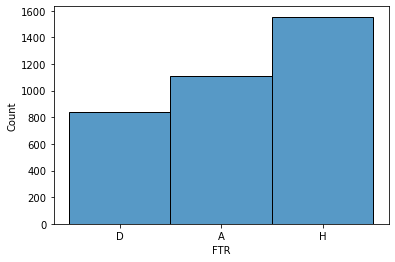

In [24]:
sns.histplot(data=fb_games_m_df,x='FTR')

<AxesSubplot: xlabel='FTR_w', ylabel='Count'>

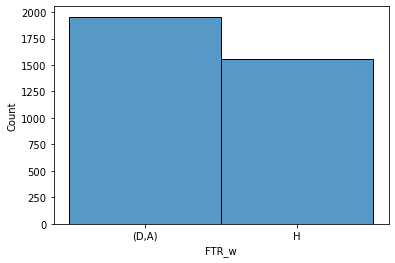

In [25]:
sns.histplot(data=fb_games_m_df,x='FTR_w')

In [26]:
fb_games_m_df.columns

Index(['FYear', 'Year', 'Month', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG',
       'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR', 'CAvgH', 'CAvgD', 'CAvgA',
       'CstdH', 'CstdD', 'CstdA', 'B365H', 'B365A', 'B365D', 'HomeTeamSquad',
       'HomeTeamAge', 'HomeTeamTmarketvalue', 'AwayTeamSquad', 'AwayTeamAge',
       'AwayTeamTmarketvalue', 'FTR_i', 'FTR_a', 'FTR_w'],
      dtype='object')

In [27]:
epl_t = mvalue_df.Club.unique()

In [28]:
dates_df = fb_games_m_df[['FYear','Year','Month','Date']].drop_duplicates().sort_values('Date')

In [29]:
stand_df = pd.DataFrame()
for index, row in dates_df.iterrows():
    stand_df = stand_df.append(pd.DataFrame([np.repeat(np.array(fb_games_m_df.iloc[index]['Date']),
                                        len(epl_t)),epl_t,[0]*len(epl_t)]).transpose())
stand_df.columns = ['Date','Club','Points']

In [30]:
stand_df = pd.merge(dates_df, stand_df ,on='Date')

In [31]:
stand_df

,FYear,Year,Month,Date,Club,Points
0,2012,2012,8,2012-08-18,Manchester Cityﾠ,0
1,2012,2012,8,2012-08-18,Manchester United,0
2,2012,2012,8,2012-08-18,Chelsea,0
3,2012,2012,8,2012-08-18,Arsenal,0
4,2012,2012,8,2012-08-18,Tottenham,0
...,...,...,...,...,...,...
42395,2021,2022,5,2022-05-22,Wolves,0
42396,2021,2022,5,2022-05-22,Sheffield United,0
42397,2021,2022,5,2022-05-22,Leeds,0
42398,2021,2022,5,2022-05-22,Brentford,0


In [32]:
t_codes = pd.DataFrame([epl_t,range(len(epl_t))]).transpose()
t_codes.columns=['Club','Club_code']

In [33]:
stand_df['Points'] = 0
stand_df['GS'] = 0
stand_df['GC'] = 0
stand_df['AvgGS'] = 0
stand_df['AvgGC'] = 0

In [34]:
stand_dyn_df = pd.DataFrame(columns=['Date','Club','Points','GS','GC','AvgGS','AvgGC','GHS','GHC','GAS','GAC'])
stand_dyn_df['Points'] = 0
stand_dyn_df['GS'] = 0
stand_dyn_df['GC'] = 0
stand_dyn_df['AvgGS'] = 0
stand_dyn_df['AvgGC'] = 0

In [35]:
stand_dyn_df

,Date,Club,Points,GS,GC,AvgGS,AvgGC,GHS,GHC,GAS,GAC


In [36]:
fb_games_m_df[fb_games_m_df['Date'] == '2021-05-16']

,FYear,Year,Month,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,...,B365D,HomeTeamSquad,HomeTeamAge,HomeTeamTmarketvalue,AwayTeamSquad,AwayTeamAge,AwayTeamTmarketvalue,FTR_i,FTR_a,FTR_w
2770,2020,2021,5,2021-05-16,Crystal Palace,Aston Villa,3,2,H,1,...,3.60,36,27.7,193.85,53,23.3,430.75,0,0,H
2849,2020,2021,5,2021-05-16,West Brom,Liverpool,1,2,A,1,...,6.50,43,26.1,141.15,43,24.4,969.65,1,1,"(D,A)"
2987,2020,2021,5,2021-05-16,Everton,Sheffield United,0,1,A,0,...,4.75,44,24.7,511.20,40,24.9,149.85,1,1,"(D,A)"
3058,2020,2021,5,2021-05-16,Tottenham,Wolves,2,0,H,1,...,4.33,41,24.6,703.50,38,23.9,450.30,0,0,H


In [39]:
def calcAllDyn(X):
    ghs = {}
    ghc = {}
    gas = {}
    gac = {}
    td = {}
    mgs = {}
    mgc = {}
    gs = {}
    gc = {}
    N=0

    X = X.sort_values('Date')
    for i in epl_t:
        ghs[i] = 0
        ghc[i] = 0
        gas[i] = 0
        gac[i] = 0
        td[i] = 0
        mgs[i] = 0
        mgc[i] = 0
        gs[i] = 0
        gc[i] = 0
    
    dat_l =  X['Date'].unique()

    for dt in dat_l:
        Y = X[X['Date'] == dt]
        for i in epl_t:
            stand_dyn_df.loc[len(stand_dyn_df.index)] = [dt,i,td[i],gs[i],gc[i],mgs[i],mgc[i],
                                                         ghs[i],ghc[i],gas[i],gac[i]]
        
        for index,row in Y.iterrows():
            
            N = N + 1
            a = 1/float(N)

            if row['FTR'] == 'H':
                td[row['HomeTeam']] = td[row['HomeTeam']] + 3
            elif row['FTR'] == 'A':
                td[row['AwayTeam']] = td[row['AwayTeam']] + 3
            else:
                td[row['HomeTeam']] = td[row['HomeTeam']] + 1
                td[row['AwayTeam']] = td[row['AwayTeam']] + 1

            ghs[row['HomeTeam']] = ghs[row['HomeTeam']] + row['FTHG']
            ghc[row['HomeTeam']] = ghc[row['HomeTeam']] + row['FTAG']
            gas[row['AwayTeam']] = gas[row['AwayTeam']] + row['FTAG']
            gac[row['AwayTeam']] = gac[row['AwayTeam']] + row['FTHG']

            mgs[row['HomeTeam']] = (1-a)*mgs[row['HomeTeam']] + a*row['FTHG']
            mgc[row['HomeTeam']] = (1-a)*mgc[row['HomeTeam']] + a*row['FTAG']
            mgs[row['AwayTeam']] = (1-a)*mgs[row['AwayTeam']] + a*row['FTAG']
            mgc[row['AwayTeam']] = (1-a)*mgc[row['AwayTeam']] + a*row['FTHG']

            gs[row['HomeTeam']] = gs[row['HomeTeam']] + row['FTHG']
            gc[row['HomeTeam']] = gc[row['HomeTeam']] + row['FTAG']
            gs[row['AwayTeam']] = gs[row['AwayTeam']] + row['FTAG']
            gc[row['AwayTeam']] = gc[row['AwayTeam']] + row['FTHG']
    print(gs,gc)

In [40]:
fb_games_m_df.groupby('FYear').apply(calcAllDyn)

{'Manchester Cityﾠ ': 0, 'Manchester United': 0, 'Chelsea': 72, 'Arsenal': 67, 'Tottenham': 56, 'Liverpool': 61, 'Newcastle': 38, 'Everton': 48, 'Sunderland': 38, 'Queens Park Rangers': 0, 'Fulham': 43, 'Aston Villa': 41, 'Stoke': 28, 'West Ham': 39, 'Swansea': 36, 'West Brom': 42, 'Wigan': 44, 'Southampton': 37, 'Norwich': 33, 'Reading': 39, 'Manchester City': 0, 'Manchester Unitedﾠ ': 0, 'Cardiff': 0, 'Crystal Palace': 0, 'Hull': 0, 'Queens Park Rangersﾠﾠ': 0, 'Leicester': 0, 'Burnley': 0, 'Man City': 0, 'Man United': 0, 'Watford': 0, 'Bournemouth': 0, 'Middlesbrough': 0, 'Brighton': 0, 'Huddersfield': 0, 'Wolves': 0, 'Sheffield United': 0, 'Leeds': 0, 'Brentford': 0, 'Nottm Forest': 0} {'Manchester Cityﾠ ': 0, 'Manchester United': 0, 'Chelsea': 33, 'Arsenal': 31, 'Tottenham': 39, 'Liverpool': 35, 'Newcastle': 53, 'Everton': 36, 'Sunderland': 44, 'Queens Park Rangers': 0, 'Fulham': 48, 'Aston Villa': 54, 'Stoke': 35, 'West Ham': 46, 'Swansea': 46, 'West Brom': 44, 'Wigan': 59, 'South

{'Manchester Cityﾠ ': 0, 'Manchester United': 0, 'Chelsea': 63, 'Arsenal': 73, 'Tottenham': 67, 'Liverpool': 89, 'Newcastle': 42, 'Everton': 54, 'Sunderland': 0, 'Queens Park Rangers': 0, 'Fulham': 34, 'Aston Villa': 0, 'Stoke': 0, 'West Ham': 52, 'Swansea': 0, 'West Brom': 0, 'Wigan': 0, 'Southampton': 45, 'Norwich': 0, 'Reading': 0, 'Manchester City': 0, 'Manchester Unitedﾠ ': 0, 'Cardiff': 34, 'Crystal Palace': 51, 'Hull': 0, 'Queens Park Rangersﾠﾠ': 0, 'Leicester': 51, 'Burnley': 45, 'Man City': 95, 'Man United': 65, 'Watford': 52, 'Bournemouth': 56, 'Middlesbrough': 0, 'Brighton': 35, 'Huddersfield': 22, 'Wolves': 47, 'Sheffield United': 0, 'Leeds': 0, 'Brentford': 0, 'Nottm Forest': 0} {'Manchester Cityﾠ ': 0, 'Manchester United': 0, 'Chelsea': 39, 'Arsenal': 51, 'Tottenham': 39, 'Liverpool': 22, 'Newcastle': 48, 'Everton': 46, 'Sunderland': 0, 'Queens Park Rangers': 0, 'Fulham': 81, 'Aston Villa': 0, 'Stoke': 0, 'West Ham': 55, 'Swansea': 0, 'West Brom': 0, 'Wigan': 0, 'Southamp

""


In [41]:
stand_df = stand_dyn_df.copy()

In [42]:
stand_df['ClubR'] = stand_df['GS'] - stand_df['GC']
stand_df['ClubAvgR'] = stand_df['AvgGS'] - stand_df['AvgGC'] 

In [43]:
stand_df['ClubHR'] = stand_df['GHS'] - stand_df['GHC']
stand_df['ClubAR'] = stand_df['GAS'] - stand_df['GAC']

In [44]:
stand_df[stand_df['Date']=='2021-05-16'].shape

(40, 15)

In [45]:
stand_df[stand_df['Date']=='2021-05-16']

,Date,Club,Points,GS,GC,AvgGS,AvgGC,GHS,GHC,GAS,GAC,ClubR,ClubAvgR,ClubHR,ClubAR
37320,2021-05-16,Manchester Cityﾠ,0,0,0,0.000000,0.000000,0,0,0,0,0,0.000000,0,0
37321,2021-05-16,Manchester United,0,0,0,0.000000,0.000000,0,0,0,0,0,0.000000,0,0
37322,2021-05-16,Chelsea,64,55,33,0.794560,0.478177,29,17,26,16,22,0.316383,12,10
37323,2021-05-16,Arsenal,55,50,38,2.452921,0.379534,22,21,28,17,12,2.073386,1,11
37324,2021-05-16,Tottenham,56,61,41,0.745014,0.511129,32,18,29,23,20,0.233886,14,6
37325,2021-05-16,Liverpool,60,61,41,1.979920,1.434807,27,20,34,21,20,0.545113,7,13
37326,2021-05-16,Newcastle,39,43,62,0.786900,0.567075,25,33,18,29,-19,0.219825,-8,-11
37327,2021-05-16,Everton,56,46,42,0.946883,0.524898,23,27,23,15,4,0.421985,-4,8
37328,2021-05-16,Sunderland,0,0,0,0.000000,0.000000,0,0,0,0,0,0.000000,0,0
37329,2021-05-16,Queens Park Rangers,0,0,0,0.000000,0.000000,0,0,0,0,0,0.000000,0,0


In [46]:
fb_games_m_df = pd.merge(fb_games_m_df,stand_df[['Date','Club','Points']].rename({'Club':'HomeTeam',
                                                                                  'Points':'HomeTeamP'},axis=1), on=['HomeTeam','Date'])
fb_games_m_df = pd.merge(fb_games_m_df,stand_df[['Date','Club','Points']].rename({'Club':'AwayTeam',
                                                                                 'Points':'AwayTeamP'},axis=1), on=['AwayTeam','Date'])

In [47]:
fb_games_m_df = pd.merge(fb_games_m_df,stand_df[['Date','Club','ClubAvgR']].rename({'Club':'HomeTeam',
                                                                                  'ClubAvgR':'HomeTeamAvgR'},axis=1), on=['HomeTeam','Date'])
fb_games_m_df = pd.merge(fb_games_m_df,stand_df[['Date','Club','ClubAvgR']].rename({'Club':'AwayTeam',
                                                                                 'ClubAvgR':'AwayTeamAvgR'},axis=1), on=['AwayTeam','Date'])

In [48]:
fb_games_m_df = pd.merge(fb_games_m_df,stand_df[['Date','Club','ClubR']].rename({'Club':'HomeTeam',
                                                                                  'ClubR':'HomeTeamR'},axis=1), on=['HomeTeam','Date'])
fb_games_m_df = pd.merge(fb_games_m_df,stand_df[['Date','Club','ClubR']].rename({'Club':'AwayTeam',
                                                                                 'ClubR':'AwayTeamR'},axis=1), on=['AwayTeam','Date'])

In [49]:
fb_games_m_df = pd.merge(fb_games_m_df,stand_df[['Date','Club','ClubHR']].rename({'Club':'HomeTeam'},axis=1), on=['HomeTeam','Date'])
fb_games_m_df = pd.merge(fb_games_m_df,stand_df[['Date','Club','ClubAR']].rename({'Club':'AwayTeam'},axis=1), on=['AwayTeam','Date'])

In [50]:
fb_games_m_df.columns

Index(['FYear', 'Year', 'Month', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG',
       'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR', 'CAvgH', 'CAvgD', 'CAvgA',
       'CstdH', 'CstdD', 'CstdA', 'B365H', 'B365A', 'B365D', 'HomeTeamSquad',
       'HomeTeamAge', 'HomeTeamTmarketvalue', 'AwayTeamSquad', 'AwayTeamAge',
       'AwayTeamTmarketvalue', 'FTR_i', 'FTR_a', 'FTR_w', 'HomeTeamP',
       'AwayTeamP', 'HomeTeamAvgR', 'AwayTeamAvgR', 'HomeTeamR', 'AwayTeamR',
       'ClubHR', 'ClubAR'],
      dtype='object')

In [51]:
fb_games_m_df['MatchR'] = fb_games_m_df['HomeTeamR'] - fb_games_m_df['AwayTeamR']
fb_games_m_df['MatchAvgR'] = fb_games_m_df['HomeTeamAvgR'] - fb_games_m_df['AwayTeamAvgR']

In [52]:
fb_games_m_df = fbetl.add_ftr_binary(fb_games_m_df)

In [53]:
fb_games_m_df.columns

Index(['FYear', 'Year', 'Month', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG',
       'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR', 'CAvgH', 'CAvgD', 'CAvgA',
       'CstdH', 'CstdD', 'CstdA', 'B365H', 'B365A', 'B365D', 'HomeTeamSquad',
       'HomeTeamAge', 'HomeTeamTmarketvalue', 'AwayTeamSquad', 'AwayTeamAge',
       'AwayTeamTmarketvalue', 'FTR_i', 'FTR_a', 'FTR_w', 'HomeTeamP',
       'AwayTeamP', 'HomeTeamAvgR', 'AwayTeamAvgR', 'HomeTeamR', 'AwayTeamR',
       'ClubHR', 'ClubAR', 'MatchR', 'MatchAvgR'],
      dtype='object')

In [54]:
fb_games_m_df = pd.merge(fb_games_m_df,t_codes.rename({'Club':'HomeTeam','Club_code':'Club_code_H'},axis=1), on=['HomeTeam'])
fb_games_m_df = pd.merge(fb_games_m_df,t_codes.rename({'Club':'AwayTeam','Club_code':'Club_code_A'},axis=1), on=['AwayTeam'])

In [55]:
fb_games_m_df = fb_games_m_df.sort_values('Date')

In [248]:
fb_games_m_df = fb_games_m_df.reset_index().drop('index',axis=1)

In [249]:
fb_games_m_df.to_pickle('epl_feat.pckl')

In [250]:
fb_games_m_df.head()

,FYear,Year,Month,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,...,HomeTeamAvgR,AwayTeamAvgR,HomeTeamR,AwayTeamR,ClubHR,ClubAR,MatchR,MatchAvgR,Club_code_H,Club_code_A
0,2012,2012,8,2012-08-18,Arsenal,Sunderland,0,0,D,0,...,0.0,0.0,0,0,0,0,0,0.0,3,8
1,2012,2012,8,2012-08-18,Newcastle,Tottenham,2,1,H,0,...,0.0,0.0,0,0,0,0,0,0.0,6,4
2,2012,2012,8,2012-08-18,West Brom,Liverpool,3,0,H,1,...,0.0,0.0,0,0,0,0,0,0.0,15,5
3,2012,2012,8,2012-08-18,West Ham,Aston Villa,1,0,H,1,...,0.0,0.0,0,0,0,0,0,0.0,13,11
4,2012,2012,8,2012-08-18,Fulham,Norwich,5,0,H,2,...,0.0,0.0,0,0,0,0,0,0.0,10,18


In [236]:
fb_games_m_df.columns

Index(['FYear', 'Year', 'Month', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG',
       'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR', 'CAvgH', 'CAvgD', 'CAvgA',
       'CstdH', 'CstdD', 'CstdA', 'B365H', 'B365A', 'B365D', 'HomeTeamSquad',
       'HomeTeamAge', 'HomeTeamTmarketvalue', 'AwayTeamSquad', 'AwayTeamAge',
       'AwayTeamTmarketvalue', 'FTR_i', 'FTR_a', 'FTR_w', 'HomeTeamP',
       'AwayTeamP', 'HomeTeamAvgR', 'AwayTeamAvgR', 'HomeTeamR', 'AwayTeamR',
       'ClubHR', 'ClubAR', 'MatchR', 'MatchAvgR', 'Club_code_H',
       'Club_code_A'],
      dtype='object')

In [59]:
###### HERE we read! ######

In [60]:
# fb_games_m_df = pd.read_pickle('epl_feat.pckl')

In [61]:
fb_games_m_df['Club_code_H'] = fb_games_m_df['Club_code_H'].astype(int)
fb_games_m_df['Club_code_A'] = fb_games_m_df['Club_code_A'].astype(int)

In [251]:
fb_games_m_df[['FTR_i','CAvgH', 'CAvgD', 'CAvgA',
       'CstdH', 'CstdD', 'CstdA', 'HomeTeamSquad',
       'HomeTeamAge', 'HomeTeamTmarketvalue', 'AwayTeamSquad', 'AwayTeamAge',
       'AwayTeamTmarketvalue', 'HomeTeamP', 'AwayTeamP', 'HomeTeamAvgR',
       'AwayTeamAvgR', 'HomeTeamR', 'AwayTeamR', 'MatchR', 'MatchAvgR', 
                'Club_code_H', 'Club_code_A', 'ClubHR', 'ClubAR']].corr()[['FTR_i']].sort_values('FTR_i',ascending=True).head()

,FTR_i
CAvgA,-0.333616
MatchR,-0.298571
CstdA,-0.273738
HomeTeamTmarketvalue,-0.248283
HomeTeamR,-0.228577


<AxesSubplot: >

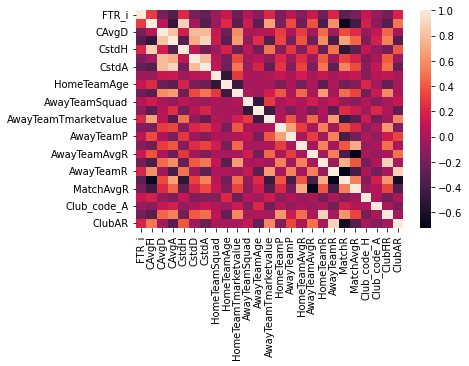

In [63]:
corr = fb_games_m_df[['FTR_i' ,'CAvgH', 'CAvgD', 'CAvgA',
       'CstdH', 'CstdD', 'CstdA', 'HomeTeamSquad',
       'HomeTeamAge', 'HomeTeamTmarketvalue', 'AwayTeamSquad', 'AwayTeamAge',
       'AwayTeamTmarketvalue', 'HomeTeamP', 'AwayTeamP', 'HomeTeamAvgR',
       'AwayTeamAvgR', 'HomeTeamR', 'AwayTeamR', 'MatchR', 'MatchAvgR', 
                'Club_code_H', 'Club_code_A', 'ClubHR', 'ClubAR']].corr()
sns.heatmap(fb_games_m_df[['FTR_i','CAvgH', 'CAvgD', 'CAvgA',
       'CstdH', 'CstdD', 'CstdA', 'HomeTeamSquad',
       'HomeTeamAge', 'HomeTeamTmarketvalue', 'AwayTeamSquad', 'AwayTeamAge',
       'AwayTeamTmarketvalue', 'HomeTeamP', 'AwayTeamP', 'HomeTeamAvgR',
       'AwayTeamAvgR', 'HomeTeamR', 'AwayTeamR', 'MatchR', 'MatchAvgR', 
                'Club_code_H', 'Club_code_A', 'ClubHR', 'ClubAR']].corr())

<AxesSubplot: >

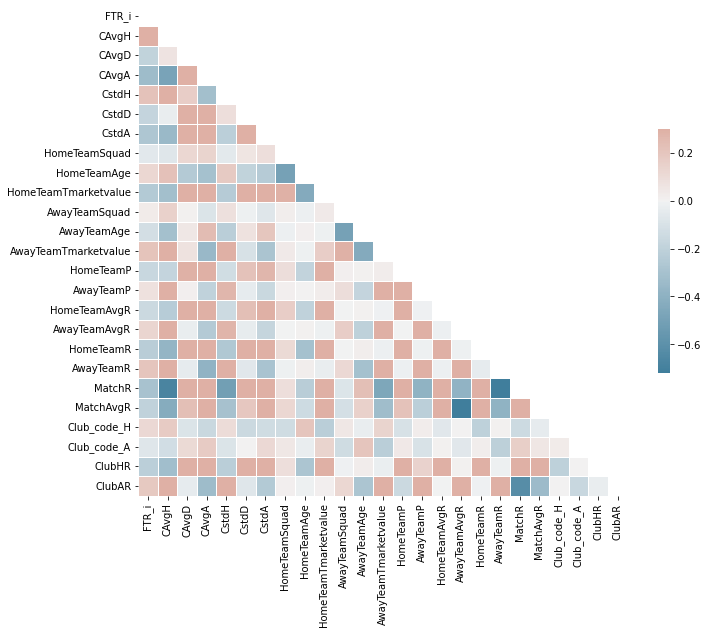

In [64]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [252]:
fb_games_m_df[['CAvgH', 'CAvgD', 'CAvgA',
       'CstdH', 'CstdD', 'CstdA', 'HomeTeamSquad',
       'HomeTeamAge', 'HomeTeamTmarketvalue', 'AwayTeamSquad', 'AwayTeamAge',
       'AwayTeamTmarketvalue', 'HomeTeamP', 'AwayTeamP', 'HomeTeamAvgR',
       'AwayTeamAvgR', 'HomeTeamR', 'AwayTeamR', 'MatchR', 'MatchAvgR', 
                'Club_code_H', 'Club_code_A', 'ClubHR', 'ClubAR']].corr()

,CAvgH,CAvgD,CAvgA,CstdH,CstdD,CstdA,HomeTeamSquad,HomeTeamAge,HomeTeamTmarketvalue,AwayTeamSquad,...,HomeTeamAvgR,AwayTeamAvgR,HomeTeamR,AwayTeamR,MatchR,MatchAvgR,Club_code_H,Club_code_A,ClubHR,ClubAR
CAvgH,1.000000,0.063574,-0.488206,0.876373,-0.033636,-0.352839,-0.071599,0.222178,-0.322239,0.147234,...,-0.233274,0.380657,-0.376632,0.602758,-0.678665,-0.429939,0.174873,-0.128541,-0.325451,0.508253
CAvgD,0.063574,1.000000,0.821042,0.161176,0.790771,0.779560,0.121988,-0.243541,0.596218,0.004767,...,0.303836,-0.027847,0.465219,-0.042990,0.352023,0.232004,-0.085152,0.110500,0.446519,-0.043320
CAvgA,-0.488206,0.821042,1.000000,-0.319943,0.723674,0.904181,0.132836,-0.308034,0.647355,-0.090853,...,0.383744,-0.245239,0.591483,-0.385773,0.677075,0.440256,-0.162776,0.178609,0.549304,-0.332322
CstdH,0.876373,0.161176,-0.319943,1.000000,0.087017,-0.217948,-0.054656,0.183298,-0.241438,0.078704,...,-0.150594,0.279585,-0.262319,0.484616,-0.517598,-0.301277,0.097302,-0.088162,-0.222751,0.396513
CstdD,-0.033636,0.790771,0.723674,0.087017,1.000000,0.784594,0.059912,-0.191765,0.346768,-0.016051,...,0.235382,-0.039167,0.405262,-0.063543,0.324741,0.192065,-0.157950,0.002548,0.401843,-0.068841
CstdA,-0.352839,0.779560,0.904181,-0.217948,0.784594,1.000000,0.086497,-0.236333,0.506780,-0.069641,...,0.323240,-0.177227,0.504056,-0.292851,0.552113,0.350273,-0.142847,0.112644,0.478911,-0.252458
HomeTeamSquad,-0.071599,0.121988,0.132836,-0.054656,0.059912,0.086497,1.000000,-0.494415,0.292944,0.017048,...,0.161593,-0.006311,0.110407,-0.012187,0.084919,0.117433,-0.143057,0.047226,0.086463,0.011042
HomeTeamAge,0.222178,-0.243541,-0.308034,0.183298,-0.191765,-0.236333,-0.494415,1.000000,-0.441226,-0.019540,...,-0.200828,0.005579,-0.308164,0.020318,-0.227527,-0.144358,0.207407,-0.035019,-0.275324,-0.011699
HomeTeamTmarketvalue,-0.322239,0.596218,0.647355,-0.241438,0.346768,0.506780,0.292944,-0.441226,1.000000,0.035604,...,0.459071,-0.012662,0.647078,-0.030880,0.469591,0.329923,-0.226562,0.138735,0.582885,0.008713
AwayTeamSquad,0.147234,0.004767,-0.090853,0.078704,-0.016051,-0.069641,0.017048,-0.019540,0.035604,1.000000,...,-0.005901,0.162979,-0.002356,0.116325,-0.082262,-0.118358,0.047226,-0.143057,-0.010490,0.117676


In [66]:
fbetl.feat_l = [ 'CAvgH', 'CAvgD', 'CAvgA',
       'CstdH', 'CstdD', 'CstdA', 'HomeTeamSquad',
       'HomeTeamAge', 'HomeTeamTmarketvalue', 'AwayTeamSquad', 'AwayTeamAge',
       'AwayTeamTmarketvalue', 'HomeTeamP', 'AwayTeamP', 'HomeTeamAvgR',
       'AwayTeamAvgR', 'HomeTeamR', 'AwayTeamR', 'ClubHR', 'ClubAR', 'MatchR',
       'MatchAvgR', 'Club_code_H', 'Club_code_A']

In [67]:
fbetl.feat_l

['CAvgH',
 'CAvgD',
 'CAvgA',
 'CstdH',
 'CstdD',
 'CstdA',
 'HomeTeamSquad',
 'HomeTeamAge',
 'HomeTeamTmarketvalue',
 'AwayTeamSquad',
 'AwayTeamAge',
 'AwayTeamTmarketvalue',
 'HomeTeamP',
 'AwayTeamP',
 'HomeTeamAvgR',
 'AwayTeamAvgR',
 'HomeTeamR',
 'AwayTeamR',
 'ClubHR',
 'ClubAR',
 'MatchR',
 'MatchAvgR',
 'Club_code_H',
 'Club_code_A']

In [253]:
bs_l = []
for year in fb_games_m_df.FYear.unique()[7:]:
    print(year)
    X_train, y_train, X_test, y_test, Y_test, X_test_odds = fbetl.split_fyear(fb_games_m_df, year, -100, False)
    
    predicted_l = np.ones(X_test.shape[0])

    accuracy = fb_experiment.accuracy_score(y_test, predicted_l )
    
    p_l = []
    l = X_test[['CAvgH','CAvgD','CAvgA']].idxmin(axis=1)
    for i in l:
        if i == 'CAvgH':
            p_l.append(0)
        else:
            p_l.append(1)
    accuracy2 = fb_experiment.accuracy_score(y_test, p_l )
    bs_l.append([year, accuracy,accuracy2])
    

2019
2020
2021


In [254]:
pd.DataFrame(bs_l,columns=['Season','Naive Model Accuracy','Rule Based Model Accuracy'])

,Season,Naive Model Accuracy,Rule Based Model Accuracy
0,2019,0.524862,0.602210
1,2020,0.613333,0.640000
2,2021,0.563452,0.654822


In [256]:
best_grid = {'boosting_type': 'gbdt',
 'colsample_bytree': 0.9,
 'learning_rate': 0.05,
 'max_depth': 4,
 'min_child_weight': 1,
 'n_estimators': 50,
 'num_leaves': 8,
 'objective': 'binary',
 'reg_alpha': 2,
 'reg_lambda': 6,
 'seed': 500,
 'subsample': 0.75}

In [257]:
res_lgb = []
for year in fb_games_m_df.FYear.unique()[7:]:
    print(year)
    model = LGBMClassifier(**best_grid)
    X_train, y_train, X_test, y_test, Y_test, X_test_odds = fbetl.split_fyear(fb_games_m_df, year, -100, False)
    model, scaler, pca, qt = fbetl.model_fit(model, X_train, y_train, scale=True, pca_apply=False, quantile_tr=False)
    predicted_l = fbetl.model_predict(model, X_test, scale=True, pca_apply=False, 
                                  quant_tr=False, scaler=scaler, pca=pca, qt=None, prob=False)
    predicted_prob_l = fbetl.model_predict(model, X_test, scale=True, pca_apply=False, 
                                  quant_tr=False, scaler=scaler, pca=pca, qt=None, prob=True)

    accuracy = fb_experiment.accuracy_score(y_test, predicted_l )
    precision = fb_experiment.precision_score(y_test, predicted_l)
    recall = fb_experiment.recall_score(y_test, predicted_l)
    auc = fb_experiment.roc_auc_score(y_test, predicted_prob_l[:,1])
    res_lgb.append([year,auc,accuracy,precision,recall])
    predicted_l = fbetl.model_predict(model, X_train, scale=True, pca_apply=False, 
                                  quant_tr=False, scaler=scaler, pca=pca, qt=None, prob=False)
    print(fbetl.model_evaluate(y_train, predicted_l, verbose=False, prob=False, threshold=0.6))

2019
(0.6963799143635656, 0.6905775075987842, 0.8073916133617626)
2020
(0.6950086058519793, 0.6898936170212766, 0.810625)
2021
(0.6939329912466042, 0.6896709323583181, 0.8183297180043384)


In [258]:
res_lgb

[[2019, 0.7060587515299879, 0.6906077348066298, 0.672566371681416, 0.8],
 [2020,
  0.7134765950358155,
  0.6888888888888889,
  0.7394366197183099,
  0.7608695652173914],
 [2021,
  0.7510999371464487,
  0.6649746192893401,
  0.6771653543307087,
  0.7747747747747747]]

In [74]:
pthres=0.65
prf_lgb_l = []
for year in fb_games_m_df.FYear.unique()[7:]:
    print(year)
    model = LGBMClassifier(**best_grid)
    X_train, y_train, X_test, y_test, Y_test, X_test_odds = fbetl.split_fyear(fb_games_m_df, year, -100, False)
    print(X_train.shape, X_test.shape)
    model, scaler, pca, qt = fbetl.model_fit(model, X_train, y_train, scale=True, pca_apply=False, quantile_tr=False)
    predicted_l = fbetl.model_predict(model, X_test, scale=True, pca_apply=False, 
                                  quant_tr=False, scaler=scaler, pca=pca, qt=None, prob=False)
    predicted_prob_l = fbetl.model_predict(model, X_test, scale=True, pca_apply=False, 
                                  quant_tr=False, scaler=scaler, pca=pca, qt=None, prob=True)
    predicted_l = fbetl.model_predict(model, X_train, scale=True, pca_apply=False, 
                                  quant_tr=False, scaler=scaler, pca=pca, qt=None, prob=False)
    profit, g_p, hit, miss = fbetl.play_the_game(predicted_l=predicted_l, predicted_prob_l=predicted_prob_l, 
                                           X_test=X_test_odds, Y_test=Y_test, odds_thres=2.2, bet=100, threshold=pthres, 
                                           verbose=False, doubling=False)
    prf_lgb_l.append([year, profit, g_p, hit, miss])
print(prf_lgb_l)

2019
(2569, 24) (181, 24)
2020
(2905, 24) (225, 24)
2021
(3313, 24) (197, 24)
[[2019, 165.50742065335857, 7, 6, 1], [2020, 111.00932058186936, 12, 9, 3], [2021, 183.91974946584742, 34, 25, 9]]


In [75]:
res_lgb_df = pd.DataFrame(res_lgb,columns=['Season','AUC','Accuracy','Precision','Recall'])

In [76]:
res_lgb_df

,Season,AUC,Accuracy,Precision,Recall
0,2019,0.706059,0.690608,0.672566,0.800000
1,2020,0.713477,0.688889,0.739437,0.760870
2,2021,0.751100,0.664975,0.677165,0.774775


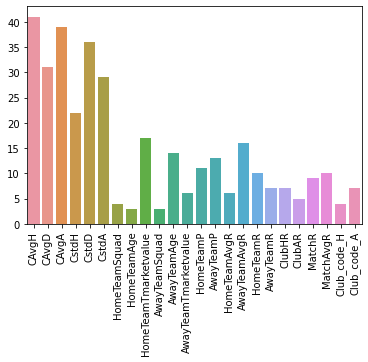

In [77]:
sns.barplot(fbetl.feat_l, model.feature_importances_)
plt.xticks(rotation=90)
plt.show()

In [78]:
pd.DataFrame(prf_lgb_l,columns=['Season','Total Profit','Games Bet On','Hit','Miss'])

,Season,Total Profit,Games Bet On,Hit,Miss
0,2019,165.507421,7,6,1
1,2020,111.009321,12,9,3
2,2021,183.919749,34,25,9


In [79]:
best_grid = {'colsample_bytree': 0.8,
 'eta': 0.05,
 'eval_metric': 'logloss',
 'gamma': 0.5,
 'max_depth': 3,
 'min_child_weight': 2,
 'n_estimators': 100,
 'random_state': 500,
 'subsample': 0.8,
 'use_label_encoder': False}

In [81]:
pthres=0.6
prf_xgb_l = []
for year in fb_games_m_df.FYear.unique()[7:]:
    print(year)
    model = XGBClassifier(**best_grid)
    X_train, y_train, X_test, y_test, Y_test, X_test_odds = fbetl.split_fyear(fb_games_m_df, year, -100, False)
    print(X_train.shape, X_test.shape)
    model, scaler, pca, qt = fbetl.model_fit(model, X_train, y_train, scale=True, pca_apply=False, quantile_tr=False)
    predicted_l = fbetl.model_predict(model, X_test, scale=True, pca_apply=False, 
                                  quant_tr=False, scaler=scaler, pca=pca, qt=None, prob=False)
    predicted_prob_l = fbetl.model_predict(model, X_test, scale=True, pca_apply=False, 
                                  quant_tr=False, scaler=scaler, pca=pca, qt=None, prob=True)
    profit, g_p, hit, miss = fbetl.play_the_game(predicted_l, predicted_prob_l, X_test_odds, Y_test, 2, 100, pthres, False)
    prf_xgb_l.append([year, profit, g_p, hit, miss])
print(prf_xgb_l)

2019
(2569, 24) (181, 24)
2020
(2905, 24) (225, 24)
2021
(3313, 24) (197, 24)
[[2019, 242.1138703102818, 47, 33, 14], [2020, 69.7268457757923, 55, 38, 17], [2021, 102.78997408483121, 51, 36, 15]]


In [84]:
res_xgb = []
for year in fb_games_m_df.FYear.unique()[7:]:
    print(year)
    model = XGBClassifier(**best_grid)
    X_train, y_train, X_test, y_test, Y_test, X_test_odds = fbetl.split_fyear(fb_games_m_df, year, -100, False)
    model, scaler, pca, qt = fbetl.model_fit(model, X_train, y_train, scale=True, pca_apply=False, quantile_tr=False)
    predicted_l = fbetl.model_predict(model, X_test, scale=True, pca_apply=False, 
                                  quant_tr=False, scaler=scaler, pca=pca, qt=None, prob=False)
    predicted_prob_l = fbetl.model_predict(model, X_test, scale=True, pca_apply=False, 
                                  quant_tr=False, scaler=scaler, pca=pca, qt=None, prob=True)
    accuracy = fb_experiment.accuracy_score(y_test, predicted_l )
    precision = fb_experiment.precision_score(y_test, predicted_l)
    recall = fb_experiment.recall_score(y_test, predicted_l)
    auc = fb_experiment.roc_auc_score(y_test, predicted_prob_l[:,1])
    res_xgb.append([year,auc,accuracy,precision,recall])
    print(fbetl.model_evaluate(y_test, predicted_l, verbose=False, prob=False, threshold=0.6))

2019
(0.6850828729281768, 0.6727272727272727, 0.7789473684210526)
2020
(0.7022222222222222, 0.7553956834532374, 0.7608695652173914)
2021
(0.6598984771573604, 0.6833333333333333, 0.7387387387387387)


In [85]:
res_xgb_df = pd.DataFrame(res_xgb,columns=['Season','AUC','Accuracy','Precision','Recall'])

In [86]:
res_xgb_df

,Season,AUC,Accuracy,Precision,Recall
0,2019,0.712118,0.685083,0.672727,0.778947
1,2020,0.708146,0.702222,0.755396,0.760870
2,2021,0.751624,0.659898,0.683333,0.738739


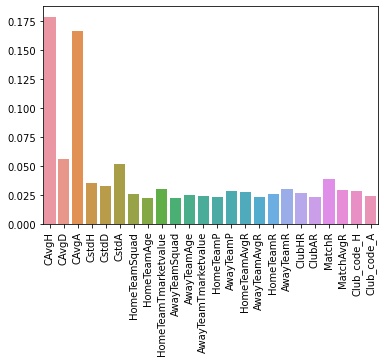

In [87]:
sns.barplot(fbetl.feat_l, model.feature_importances_)
plt.xticks(rotation=90)
plt.show()

In [88]:
pd.DataFrame(prf_xgb_l,columns=['Season','Total Profit','Games Bet On','Hit','Miss'])

,Season,Total Profit,Games Bet On,Hit,Miss
0,2019,242.113870,47,33,14
1,2020,69.726846,55,38,17
2,2021,102.789974,51,36,15


In [89]:
c_df = pd.merge(res_lgb_df[['Season','AUC']].rename({'AUC':'LGB_AUC'},axis=1), 
         res_xgb_df[['Season','AUC']].rename({'AUC':'XGB_AUC'},axis=1))

In [90]:
c_df

,Season,LGB_AUC,XGB_AUC
0,2019,0.706059,0.712118
1,2020,0.713477,0.708146
2,2021,0.751100,0.751624


In [94]:
scaler = fb_experiment.preprocessing.MinMaxScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [95]:
X_train =X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0],1, X_test.shape[1])
y_train = np.array(y_train)#.reshape(1,len(y_train))
y_test = np.array(y_test)#.reshape(1,len(y_test))

In [158]:
BATCH_SIZE=100
EPOCHS=40

In [166]:
gru_model = Sequential()
gru_model.add(Bidirectional(LSTM(128), input_shape=(X_train.shape[1],X_train.shape[2]), merge_mode='concat'))
gru_model.add(RepeatVector(64))
gru_model.add(Bidirectional(LSTM(50, return_sequences=True)))
gru_model.add(TimeDistributed(Dense(1, activation='sigmoid')))

In [171]:
gru_model = Sequential()
gru_model.add(LSTM(128, input_shape=(X_train.shape[1],X_train.shape[2])))
# gru_model.add(BatchNormalization())
gru_model.add(Dense(units=64, activation='relu'))
gru_model.add(Dropout(0.5))
gru_model.add(Dense(units=12, activation='relu'))
gru_model.add(Dense(1,activation='sigmoid'))
# print(gru_model.summary())

In [172]:
gru_model.compile(
    loss= 'binary_crossentropy',
    optimizer="adam",
    metrics=["accuracy"],
)

In [173]:
history = gru_model.fit(X_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          verbose=0,
          validation_data= (X_test,y_test)
          )

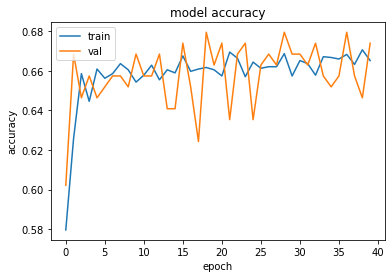

In [174]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

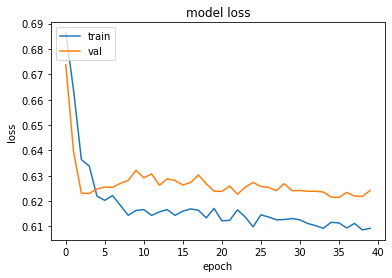

In [175]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [203]:
res_rnn = []
prf_rnn = []
BATCH_SIZE=100
EPOCHS=40
for year in fb_games_m_df.FYear.unique()[7:]:
    print(year)
    model = XGBClassifier(**best_grid)
    X_train, y_train, X_test, y_test, Y_test, X_test_odds = fbetl.split_fyear(fb_games_m_df, year, -100, False)
    scaler = fb_experiment.preprocessing.MinMaxScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    X_train =X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0],1, X_test.shape[1])
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    
    gru_model = Sequential()
    gru_model.add(LSTM(128, input_shape=(X_train.shape[1],X_train.shape[2])))
    # gru_model.add(BatchNormalization())
    gru_model.add(Dense(units=64, activation='relu'))
    gru_model.add(Dropout(0.5))
    gru_model.add(Dense(units=12, activation='relu'))
    gru_model.add(Dense(1,activation='sigmoid'))
    # print(gru_model.summary())
    
    gru_model.compile(
    loss= 'binary_crossentropy',
    optimizer="adam",
    metrics=["accuracy"])
    
    history = gru_model.fit(X_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          verbose=0,
          validation_data= (X_test,y_test))
    l = gru_model.predict(X_test)
    predicted_prob_l = np.concatenate([1-l,l],axis=1)
    predicted_l = 1*(predicted_prob_l[:,1] > 0.5)
#     predicted_l = fbetl.model_predict(model, X_test, scale=True, pca_apply=False, 
#                                   quant_tr=False, scaler=scaler, pca=pca, qt=None, prob=False)
#     predicted_prob_l = fbetl.model_predict(model, X_test, scale=True, pca_apply=False, 
#                                   quant_tr=False, scaler=scaler, pca=pca, qt=None, prob=True)
    accuracy = fb_experiment.accuracy_score(y_test, predicted_l )
    precision = fb_experiment.precision_score(y_test, predicted_l)
    recall = fb_experiment.recall_score(y_test, predicted_l)
    auc = fb_experiment.roc_auc_score(y_test, predicted_prob_l[:,1])
    res_rnn.append([year,auc,accuracy,precision,recall])
    print(fbetl.model_evaluate(y_test, predicted_l, verbose=False, prob=False, threshold=0.6))
    profit, g_p, hit, miss = fbetl.play_the_game(predicted_l, predicted_prob_l, X_test_odds, Y_test, 2, 100, 0.6, False)
    prf_rnn.append([year, profit, g_p, hit, miss])
print(prf_rnn)

2019
(0.6629834254143646, 0.6634615384615384, 0.7263157894736842)
2020
(0.6844444444444444, 0.7637795275590551, 0.7028985507246377)
2021
(0.6548223350253807, 0.6641221374045801, 0.7837837837837838)
[[2019, 80.78422787998636, 12, 8, 4], [2020, -496.97158580139603, 34, 21, 13], [2021, -667.9746995736132, 69, 42, 27]]


In [201]:
print(prf_rnn)

[[2019, 175.6935513722587, 28, 20, 8], [2020, -41.196700673410106, 56, 39, 17], [2021, -485.03648641483767, 43, 27, 16]]


In [179]:
l = gru_model.predict(X_test)

In [188]:
predicted_prob_l = np.concatenate([1-l,l],axis=1)

In [195]:
predicted_l = 1*(predicted_prob_l[:,1] > 0.5)

In [189]:
predicted_prob_l

array([[0.74426734, 0.25573263],
       [0.2119363 , 0.7880637 ],
       [0.20123023, 0.7987698 ],
       [0.37393844, 0.62606156],
       [0.34195328, 0.6580467 ],
       [0.34402096, 0.65597904],
       [0.45534384, 0.54465616],
       [0.41812772, 0.5818723 ],
       [0.2082001 , 0.7917999 ],
       [0.8012104 , 0.1987896 ],
       [0.4046389 , 0.5953611 ],
       [0.554099  , 0.44590098],
       [0.3554777 , 0.6445223 ],
       [0.6559529 , 0.34404713],
       [0.24309796, 0.75690204],
       [0.6734806 , 0.32651943],
       [0.5274372 , 0.4725628 ],
       [0.57248735, 0.42751262],
       [0.05185699, 0.948143  ],
       [0.398839  , 0.601161  ],
       [0.15932107, 0.84067893],
       [0.3609625 , 0.6390375 ],
       [0.90283495, 0.09716505],
       [0.5368852 , 0.4631148 ],
       [0.33588952, 0.6641105 ],
       [0.50654197, 0.493458  ],
       [0.2462762 , 0.7537238 ],
       [0.37286592, 0.6271341 ],
       [0.24355221, 0.7564478 ],
       [0.7321619 , 0.26783815],
       [0.